# Reading Map through STAC

In [ ]:
from datetime import datetime
import os
import json
import subprocess

import boto3
from dotenv import load_dotenv
import geopandas as gpd
from pystac_client import Client
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.session import AWSSession
from rasterio.transform import from_bounds
import rioxarray
from shapely.geometry import shape
import stackstac

## Input

Authentication

In [94]:
auth_method = "profile"
profile = "lcfm"

if auth_method != "profile":
    # Read s3 keys from .env files
    load_dotenv()
    os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
    os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")
if profile == "gaf":
    endpoint_url = "lcfm-datahub.gaf.de"
else:
    endpoint_url = "s3.waw3-1.cloudferro.com"

Query

In [95]:
shapefile = "../resources/LCFM_ONE_SAMPLE_Grids10m.geojson"
gdf_pm = gpd.read_file(shapefile)

In [96]:
from shapely.geometry import Polygon
import numpy as np

union = gdf_pm.union_all()

# Get all coordinates from the geometry exterior
coords = np.array(list(union.exterior.coords))

# Find the corners using convex hull properties
ch = union.convex_hull
ch_coords = np.array(list(ch.exterior.coords))

# Keep only the 4 most extreme points
min_x_idx = np.argmin(ch_coords[:, 0])
max_x_idx = np.argmax(ch_coords[:, 0])
min_y_idx = np.argmin(ch_coords[:, 1])
max_y_idx = np.argmax(ch_coords[:, 1])

# Get the 4 corner points
corner_indices = sorted(list(set([min_x_idx, max_x_idx, min_y_idx, max_y_idx])))

# Check if we have exactly 4 corners
if len(corner_indices) < 4:
    # Alternative approach: get the actual corners from a simplified polygon
    simplified = union.simplify(union.length / 100)  # Simplify to get fewer points
    simple_coords = np.array(list(simplified.exterior.coords))
    
    # Find points furthest from centroid
    centroid = simplified.centroid
    distances = [point.distance(centroid) for point in [Polygon([simple_coords[i:i+2]]) for i in range(len(simple_coords)-1)]]
    sorted_indices = np.argsort(distances)[-4:]  # Get 4 points furthest from centroid
    corner_points = [tuple(simple_coords[i]) for i in sorted_indices]
else:
    corner_points = [tuple(ch_coords[i]) for i in corner_indices]

# Get the centroid for initialization
centroid = union.centroid
centroid_point = (centroid.x, centroid.y)

# Initialize points with the centroid coordinates (will be replaced by actual corners)
ul = ur = ll = lr = centroid_point

for point in corner_points:
    x, y = point
    # Upper Left (lowest x, highest y)
    if x <= ul[0] and y >= ul[1]:
        ul = point
    # Upper Right (highest x, highest y)
    if x >= ur[0] and y >= ur[1]:
        ur = point
    # Lower Left (lowest x, lowest y)
    if x <= ll[0] and y <= ll[1]:
        ll = point
    # Lower Right (highest x, lowest y)
    if x >= lr[0] and y <= lr[1]:
        lr = point

# Create a properly ordered corner points list
corner_points = [ul, ur, lr, ll]
polygon = Polygon(corner_points)
print(corner_points)

[(-7287317.78886986, -651229.7052062404), (-7287217.323904815, -651230.1477818596), (-7287217.763502375, -651331.2829349549), (-7287318.228628153, -651330.8402896702)]


In [97]:
# Create a gdf from the polygon
gdf = gpd.GeoDataFrame(index=[0], crs=gdf_pm.crs, geometry=[polygon])
crs_utm = int(gdf_pm["UTM"].iloc[0])
gdf = gdf.to_crs(crs_utm)
print("Original bounds:", gdf.iloc[0].geometry.bounds)
# Update geometry with rounded bounds
gdf.geometry = gdf.geometry.apply(lambda geom: Polygon.from_bounds(*[round(bound) for bound in geom.bounds]))
print("Rounded bounds:", gdf.iloc[0].geometry.bounds)

geometry_latlon = gdf.to_crs("EPSG:4326").geometry.iloc[0]

bounds = gdf.iloc[0].geometry.bounds
span_x = bounds[2] - bounds[0]
span_y = bounds[3] - bounds[1]
print("Size [m]", span_x, span_y)

Original bounds: (227250.00000000076, 9353789.999999965, 227350.00000000076, 9353889.999999965)
Rounded bounds: (227250.0, 9353790.0, 227350.0, 9353890.0)
Size [m] 100.0 100.0


Collection parameters

In [98]:
collection = "LCFM_LCM-10_v008"
resolution = 10

In [99]:
# Define the date range for the search
year = 2020
start_date = datetime(year, 1, 1).isoformat() + "Z"
end_date = datetime(year, 12, 12).isoformat() + "Z"

## STAC query

In [100]:
# Connect to the STAC API
stac_api_url = "https://www.stac.lcfm.dataspace.copernicus.eu/"
catalog = Client.open(stac_api_url)

# Fetch items from the collection using the search method with spatial and temporal constraints
search = catalog.search(
    collections=[collection],
    datetime=f"{start_date}/{end_date}",
    intersects=geometry_latlon,
)

items = list(search.items())

if items:
    # Print items found in the collection
    print(f"Found {len(items)} items in the collection:")
    for item in items:
        print(f"- {item.id}")
else:
    print("No items found in the collection.")


Found 2 items in the collection:
- LCFM_LCM-10_V008_2020_20MKU_MAP
- LCFM_LCM-10_V008_2020_19MHP_MAP


In [101]:
# Select item from the list with matching crs
item = None
for i in items:
    if i.properties["proj:epsg"] == crs_utm:
        item = i
        break
if item:
    print(item.id)
    source_crs = crs_utm
    source_bounds = bounds
else:
    # TODO: refine the selection of the item
    item = min(items, key=lambda x: shape(x.geometry).centroid.distance(geometry_latlon.centroid))
    source_crs = item.properties["proj:epsg"]
    # Reproject
    source_bounds = gdf.to_crs(source_crs).iloc[0].geometry.bounds

LCFM_LCM-10_V008_2020_20MKU_MAP


In [102]:
# S3 session info
# If profile, pass profile_name; otherwise use keys
if auth_method == "profile":
    b3 = boto3.Session(profile_name=profile)
else:
    b3 = boto3.Session(
        aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )

aws_session = AWSSession(session=b3, endpoint_url=endpoint_url)

# 3) Tell GDAL to use path-style + your endpoint
gdal_env = stackstac.DEFAULT_GDAL_ENV.updated(
    always={
      "session":                 aws_session,
    }
)

## Read MAP asset

In [140]:
assets = ["map"]

if profile == "lcfm":
    for asset_key in assets:
        item.assets[asset_key].href = item.assets[asset_key].extra_fields["alternate"]["local"]["href"]

# Now you can use stackstac with the modified STAC item
map = stackstac.stack([item],
                          assets=assets,
                          bounds=bounds,
                          resolution=resolution,
                          epsg=source_crs,
                          fill_value=np.uint8(255),
                          dtype=np.uint8,
                          rescale=False,
                          gdal_env=gdal_env,
                          ).isel(time=0)

# Fix the coordinates
map.coords["x"] = map.coords["x"] + map.transform[0]/2
print(map.x.values)
map.coords["y"] = map.coords["y"] + map.transform[4]/2
print(map.y.values)

# Example to check the DataArray information
# map

Reproject if needed

In [141]:
# Reproject
if source_crs != crs_utm or True:
    transform = from_bounds(*bounds, (span_x/resolution), (span_y/resolution))
    map = map.rio.reproject(
        f"EPSG:{crs_utm}",
        resampling=Resampling.nearest,
        transform=transform,
    )

# Extract the bands
map_asset = map.sel(band="map")

(-0.5, 9.5, 9.5, -0.5)

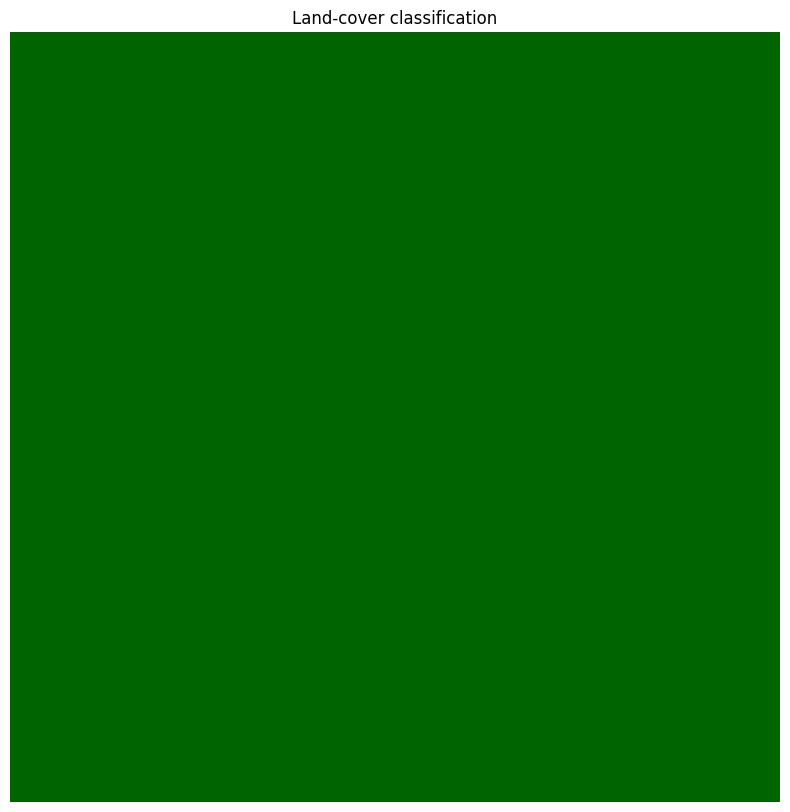

In [142]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Define your class values and corresponding hex colors
class_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
hex_colors   = [
    "#006400",  # Tree cover
    "#ffbb22",  # Shrubland
    "#ffff4c",  # Grassland
    "#f096ff",  # Cropland
    "#fa0000",  # Built-up
    "#b4b4b4",  # Bare / sparse vegetation
    "#f0f0f0",  # Snow and ice
    "#0064c8",  # Permanent water bodies
    "#0096a0",  # Herbaceous wetland
    "#fae6a0",  # Moss and lichen
    "#00cf75",  # Mangroves
]

# 2. Create a ListedColormap and a BoundaryNorm
cmap = mcolors.ListedColormap(hex_colors, name="landcover")
# we make one extra boundary above the highest value
class_bounds = class_values + [class_values[-1] + (class_values[-1] - class_values[-2])]
norm   = mcolors.BoundaryNorm(class_bounds, cmap.N)

# 3. Plot your single-band map with that colormap
plt.figure(figsize=(10, 10))
plt.imshow(
    map_asset,
    cmap=cmap,
    norm=norm
)
plt.title("Land-cover classification")
plt.axis("off")


## Write

In [ ]:
with rasterio.open(
    "map.tif", "w",
    driver="GTiff",
    height=map_asset.rio.height,
    width=map_asset.rio.width,
    count=1,
    dtype=map_asset.dtype,
    crs=map_asset.rio.crs,
    transform=map_asset.rio.transform(),
    compress="LZW",
) as dst:
    dst.write(map_asset.values, 1)

## Check

In [242]:
# Run gdalinfo on the file and read the json for the transform
import json
import subprocess

# Define the output file
output_file = "map.tif"

# Run gdalinfo command and capture the output as JSON
result = subprocess.run(["gdalinfo", output_file, "-json"], capture_output=True, text=True)

# Parse JSON output into a Python dictionary
if result.returncode == 0:
    gdalinfo = json.loads(result.stdout)
    
    # Extract key information
    transform = gdalinfo.get('geoTransform', [])
    if transform:
        print(f"GeoTransform: {transform}")
        print(f"\nPixel size (X): {transform[1]} meters")
        print(f"Pixel size (Y): {abs(transform[5])} meters")
        print(f"Upper left X: {transform[0]}")
        print(f"Upper left Y: {transform[3]}")
else:
    print(f"Error running gdalinfo: {result.stderr}")
    geotransform = None

GeoTransform: [227250.0, 10.0, 0.0, 9353890.0, 0.0, -10.0]

Pixel size (X): 10.0 meters
Pixel size (Y): 10.0 meters
Upper left X: 227250.0
Upper left Y: 9353890.0
